In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# add the path to my packages to system paths so they can be imported
import sys
# sys.path.append('/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages')
sys.path.append('F:\MAScThesis\code\my_packages')
# sys.path.append('/home/yasamanparhizkar/Documents/thesis/code/my_packages')

import my_first_feature_extractor as fe
import compare_with_benchmark as bn
import my_similarity_graph_eff_test as sg

# Load spike data

In [2]:
# load all spike data from file
data_path = '../../data/original_files/'
binned_data = np.loadtxt(data_path + 'spikes.csv', delimiter=',')
binned_data = binned_data.reshape(binned_data.shape[0], 1141, 113)

I_order_10 = [54, 35, 10, 60, 74, 9, 61, 56, 91, 104]

In [3]:
# print some statistics
print('binned_data.shape = ', binned_data.shape)

avg_spike_perc = 0
print('neuron #    | percentage belonging to class 1')
print('---------------------------------------------')
for neu_i in I_order_10:
    pers = fe.class_percentages(binned_data[0,:,neu_i], [0, 1])
    avg_spike_perc += pers[1]
    print('neuron #{:3} | {:.2f}%'.format(neu_i, pers[1]))

avg_spike_perc /= 10
print('---------------------------------------------')
print('AVERAGE     | {:.2f}% of data belongs to class 1'.format(avg_spike_perc))

binned_data.shape =  (297, 1141, 113)
neuron #    | percentage belonging to class 1
---------------------------------------------
neuron # 54 | 1.84%
neuron # 35 | 2.63%
neuron # 10 | 2.28%
neuron # 60 | 1.58%
neuron # 74 | 1.93%
neuron #  9 | 0.44%
neuron # 61 | 3.24%
neuron # 56 | 1.14%
neuron # 91 | 5.78%
neuron #104 | 2.10%
---------------------------------------------
AVERAGE     | 2.30% of data belongs to class 1


# Load feature vectors

In [4]:
neu_id = I_order_10[0]

# utility function to use when creating train and val data
def get_datapoint(index, path='../../data/slowfast_4608/', binned_data=binned_data, neuron_id=neu_id):
    """
    Return a datapoint consisting of (feature vector, label)
    based on the extended index system of the whole dataset (297 repeats of a 1141-frame movie).
    
    Inputs: path, binned_data, index
    path - path to where feature vectors are stored.
    binned_data - the original spike data of shape (297 x 1141 x 113)
    neuron_id - index of the selected neuron
    index - index of the datapoint to be returned
            Note: this index indicates time. it must be between batch_sz-1 to 1141*297-1.
    
    Output: fv, lbl
    fv - 1x9216 torch tensor representing the feature vector of the selected time bin
    lbl - scalar corresponding spike label
    """
    
    fv = torch.load(path+'fv_'+str(index%1141)+'.pt')
    lbl = binned_data[index//1141,index%1141,neuron_id]
    
    return fv, lbl

In [5]:
def random_train_val(train_num, val_num, ind_min, ind_max, get_datapoint, seed):
    """
    Create a dict of feature vectors and their corresponding labels.
    Feature vectors are loaded from a path and labels are given as an input.
    Data points are selected randomly; as a result, their indices in the new sets will NOT indicate time anymore.
    
    Input: train_num, val_num, ind_min, ind_max, path, binned_data, neuron_id
    train_num     - size of training dataset to be returned
    val_num       - size of validation dataset to be returned
    ind_min       - minimum possible datapoint index
    ind_max       - maximum possible datapoint index
    get_datapoint - function which takes an index and returns the corresponding datapoint pair (fv, lbl)
    seed          - for random selection of data points (default: None)
    
    Output: train_num, val_num, train_data, val_data
    train_num  - number of training data points
    val_num    - number of validation data points
    train_data - 
        des   - NxD numpy array of feature vectors
        lbls  - Nx1 numpy array of corresponding labels
        smpls - list of indices of chosen datapoints
    val_data  - 
        des   - NxD numpy array of feature vectors
        lbls  - Nx1 numpy array of corresponding labels
        smpls - list of indices of chosen datapoints
    """
    
    data_num = ind_max - ind_min + 1
    train_num = min(train_num, data_num)
    val_num   = min(val_num, data_num-train_num)
    
    # select indices of datapoints randomly
    rng = np.random.default_rng(seed)
    samples = rng.choice(np.arange(ind_min, ind_max+1), size=(train_num+val_num), replace=False)
    train_smpls = samples[:train_num]
    val_smpls   = samples[train_num:]
    
    # get feature vectors and labels corresponding to chosen indices
    train_des = []
    train_lbls = []
    for index in train_smpls:
        fv, lbl = get_datapoint(index)
        train_des.append(fv)
        train_lbls.append(lbl)
    train_des = torch.cat(train_des)
    train_des = train_des.detach().numpy()
    train_lbls = np.array(train_lbls)
    
    val_des = []
    val_lbls = []
    for index in val_smpls:
        fv, lbl = get_datapoint(index)
        val_des.append(fv)
        val_lbls.append(lbl)
    val_des = torch.cat(val_des)
    val_des = val_des.detach().numpy()
    val_lbls = np.array(val_lbls)
    
    train_data = {'des': train_des, 'lbls': train_lbls, 'smpls': train_smpls}
    val_data   = {'des': val_des, 'lbls': val_lbls, 'smpls': val_smpls}
    
    return train_num, val_num, train_data, val_data   

In [6]:
ind_min = 31
ind_max = 297*1141-1
data_num = ind_max - ind_min + 1
# train_num = int(data_num*0.8)
# val_num = data_num - train_num
train_num = 30
val_num = 20

train_num, val_num, train_data, val_data = \
random_train_val(train_num, val_num, ind_min, ind_max, get_datapoint, seed=1342)

print('train_num = ', train_num, ', val_num = ', val_num)
print('training data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(train_data['lbls']), np.sum(train_data['lbls'])*100/train_num))
print('validation data contains {} points ({:.2f}%) of label 1.'
      .format(np.sum(val_data['lbls']), np.sum(val_data['lbls'])*100/val_num))
# print('train_smpls = ', train_data['smpls'], '\nval_smpls = ', val_data['smpls'])
# print('train_lbls = ', train_data['lbls'])
# print('val_lbls = ', val_data['lbls'])

train_num =  30 , val_num =  20
training data contains 1.0 points (3.33%) of label 1.
validation data contains 0.0 points (0.00%) of label 1.


## Shorten feature vectors

In [45]:
# truncate feature vectors for test purposes
train_data['des']= train_data['des'][:,::10]
val_data['des']= val_data['des'][:,::10]

# for numerical stability during GD, increase norm of feature vectors
# train_data['des'] *= 10
# val_data['des'] *=  10

## Normalize feature vectors

Taken from 'code/03_mnist/sift_on_mnist/sift_on_mnist_06.ipynb' with small changes.

In [69]:
def normalize(dess, feature_nrm=1, node_nrm=1):
    """
    Normalize feature vectors.
    Inputs: dess
    dess - NxD array of features for all data points.
    
    Outputs: dess_nrm
    dess_nrm - NxD array of normalized features.
    """
    # method 2: double normalization
    # step 1 - feature-wise: subtract mean and divide by standard deviation of each feature.
    dess_mean = np.mean(dess, axis=1, keepdims=True)
    dess_std = np.std(dess, axis=1, keepdims=True)

    dess_nrm = dess - dess_mean
    dess_nrm = dess_nrm * feature_nrm / (dess_std + 0.01)


    # step 2 - smaple-wise: normalize l2-norm of each vector to a certain value.
    ideal_norm = 30
    dess_norm = np.linalg.norm(dess_nrm, axis=0, keepdims=True)
    dess_nrm = dess_nrm * node_nrm / (dess_norm + 0.01)
    
    return dess_nrm

In [70]:
train_dess_nrm = normalize(train_data['des'], feature_nrm=1, node_nrm=30)  
val_dess_nrm = normalize(val_data['des'], feature_nrm=1, node_nrm=30)

# Use the similiarity graph model on the data

In [71]:
# reload sg package
import importlib
importlib.reload(sg)

<module 'my_similarity_graph_eff_test' from '/home/yasamanparhizkar/Documents/yorku/01_thesis/code/my_packages/my_similarity_graph_eff_test.py'>

In [50]:
# learning phase
sg_opt_params = { 'epsilon0':1, 'epsilon_decay':0.5, 'epsilon_jump': 2, \
              'num_its':10, 'check_freq':1, 'print_checks':True, 'Theta0':None, \
              'force_all_its': True, 'threshold': 0.01}

B, sg_stats = sg.fit_graph(train_dess_nrm, train_data['lbls'], sg_opt_params, mux=1, D=10, seed=0, edgesx=None)

entered sg.fit_graph. Here are the inputs:
dess
 [[-0.04330423 -0.0074268  -0.02448737 ... -0.03101905 -0.03163967
   0.01029052]
 [-0.03393544 -0.03346175 -0.04236905 ... -0.03188423 -0.03183217
  -0.02071211]
 [-0.03919083 -0.04392855 -0.04452686 ... -0.03692338 -0.03775269
  -0.03104565]
 ...
 [-0.04123309 -0.0427536   0.01821695 ... -0.03399155 -0.03683655
  -0.02782824]
 [-0.04185015 -0.0492242  -0.0292194  ... -0.03504333 -0.03240783
  -0.01240579]
 [-0.01041931 -0.04406548 -0.03618603 ... -0.03095119 -0.0353319
  -0.02258123]]
lbls
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0

In [62]:
L21, L22 = sg.get_acc(B, train_dess_nrm, train_data['lbls'], val_dess_nrm, val_data['lbls'])

sg.get_acc is called. Here are the inputs:
B = 
 [[ -336.44580002   151.9050869    481.20117659 ...   -17.77806789
      2.5632442    512.7132939 ]
 [ -492.19636459    62.77990782    72.68617403 ...    42.89968688
    157.01931497   354.77290025]
 [ -570.81106226   -99.85884733  -289.54499562 ...   -94.51073468
   -104.23477198  1063.73628485]
 ...
 [ -182.67642519  -211.08460456   349.0718435  ...    36.64338556
     75.76789348  -216.42806385]
 [-1100.95400149  -184.67298816  -191.46868236 ...  -120.45840743
    -51.60432552   662.77193602]
 [ -117.41680688   -35.8849892   -834.04595026 ...   -20.14392497
     22.39512724  -248.14261688]]
train_des =
 [[-0.04330423 -0.0074268  -0.02448737 ... -0.03101905 -0.03163967
   0.01029052]
 [-0.03393544 -0.03346175 -0.04236905 ... -0.03188423 -0.03183217
  -0.02071211]
 [-0.03919083 -0.04392855 -0.04452686 ... -0.03692338 -0.03775269
  -0.03104565]
 ...
 [-0.04123309 -0.0427536   0.01821695 ... -0.03399155 -0.03683655
  -0.02782824]
 [-0.0418

In [65]:
np.linalg.inv(L22)

LinAlgError: Singular matrix

In [66]:
L22

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [56]:
# estimation phase
# acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], val_data['des'], val_data['lbls'])

# print('val acc = ', acc)
# print('estimated val labels = ', (y_est>0).astype(np.int32))

# # save results
# np.savetxt('results/sg_val_acc.txt', np.array([acc]))
# np.savetxt('results/sg_y_est.csv', y_est, delimiter=',')

sg.get_acc is called. Here are the inputs:
B = 
 [[ -336.44580002   151.9050869    481.20117659 ...   -17.77806789
      2.5632442    512.7132939 ]
 [ -492.19636459    62.77990782    72.68617403 ...    42.89968688
    157.01931497   354.77290025]
 [ -570.81106226   -99.85884733  -289.54499562 ...   -94.51073468
   -104.23477198  1063.73628485]
 ...
 [ -182.67642519  -211.08460456   349.0718435  ...    36.64338556
     75.76789348  -216.42806385]
 [-1100.95400149  -184.67298816  -191.46868236 ...  -120.45840743
    -51.60432552   662.77193602]
 [ -117.41680688   -35.8849892   -834.04595026 ...   -20.14392497
     22.39512724  -248.14261688]]
train_des =
 [[2.3562497e-02 1.4096595e-01 9.0876393e-02 ... 1.1945693e-02
  1.8916026e-02 1.8078990e-01]
 [5.0581101e-02 7.6565064e-02 3.7567660e-02 ... 1.6063600e-03
  1.2714243e-02 1.1902167e-01]
 [5.6551650e-02 7.1186699e-02 5.5011477e-02 ... 3.9027126e-03
  1.1813499e-02 1.1451350e-01]
 ...
 [4.0191192e-02 6.4670593e-02 2.2463340e-01 ... 7.1866

NameError: name 'y_est' is not defined

In [ ]:
# comparing estimated and real spike locations
loc = np.arange(val_num)
print('Estimated spike time bins: ', loc[y_est > 0])
print('Real spike time bins: ', loc[val_data['lbls']==1])
print('{:.2f}% of validation points have label 0 (= min accuracy)'.format(np.sum(val_data['lbls']==0)*100/val_num))

Coordinates of elements with higher values than 7
[(42, 34), (34, 42), (42, 42), (70, 51), (70, 52), (51, 70), (52, 70), (70, 70), (73, 70), (77, 70), (84, 70), (96, 70), (106, 70), (126, 70), (157, 70), (187, 70), (199, 70), (239, 70), (256, 70), (275, 70), (279, 70), (291, 70), (303, 70), (313, 70), (326, 70), (335, 70), (338, 70), (340, 70), (344, 70), (383, 70), (427, 70), (433, 70), (70, 73), (70, 77), (70, 84), (70, 96), (70, 106), (106, 106), (70, 126), (70, 157), (70, 187), (70, 199), (70, 239), (70, 256), (70, 275), (70, 279), (70, 291), (70, 303), (303, 303), (70, 313), (70, 326), (70, 335), (70, 338), (70, 340), (70, 344), (70, 383), (70, 427), (70, 433)]


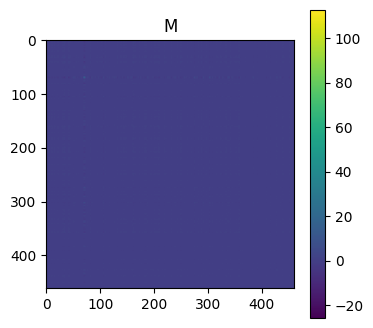

In [85]:
# display learned M
M = B.T @ B
# to preserve memory, uncomment below line
# del B

sg.display_matrix(M, 'M')

# mark elements with high values
lim = 7 # marker threshold
f_sz = M.shape[0]
xloc = np.broadcast_to(np.arange(f_sz), (f_sz, f_sz))
yloc = xloc.T
# plt.plot(xloc[M > lim],yloc[M > lim], marker='o', markersize=3, color='r', linestyle='')
print('Coordinates of elements with higher values than {}'.format(lim))
print(list(zip(xloc[M > lim],yloc[M > lim])))

# save results
plt.savefig('results/sg_finalM.png')
np.savetxt('results/sg_finalB.csv', B, delimiter=',')

In [ ]:
# Some informative figures to compare forced and flexible time complexity
plt.figure(figsize=(6,3))
plt.plot(sg_stats['train_losss'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('loss')
plt.title('Training loss of each iteration', fontsize=10)
plt.savefig('results/sg_trainlosss.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['it_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Elapsed time after each iteration since the start of the algorithm', fontsize=10)
plt.savefig('results/sg_runtime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['eval_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to evaluate loss and its derivative in each iteration', fontsize=10)
plt.savefig('results/sg_evallosstime.png')

plt.figure(figsize=(6,3))
plt.plot(sg_stats['stepsizeloop_times'], marker='o')
plt.xlabel('iteration number')
plt.ylabel('time (sec)')
plt.title('Time spent to find a valid stepsize in each iteration', fontsize=10)
plt.savefig('results/sg_epsilontime.png')

(0.0008033950504377376, 4815600.0)

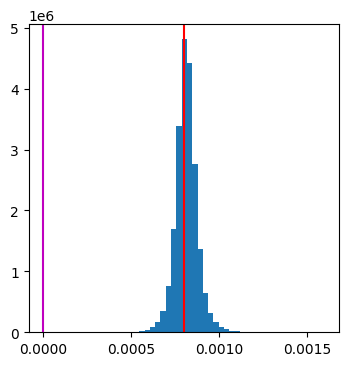

In [19]:
sg.hist_of_entries(M, 50, zeroline=True, peakline=True)
plt.title('Histogram of M entries')

## Assess the graph model's performance and running time

In [41]:
# utility function to use with 'bn.assess' method
def get_sg_acc(train_data, val_data, sg_opt_params=sg_opt_params, D=1):
    """
    Fit similarity graph to training data and measure accuracy on validation set.
    NOTE: sg_opt_params, D are used from outside of the function.
    """
    B, stats = sg.fit_graph(train_data['des'], train_data['lbls'], \
                                      sg_opt_params, D=D, seed = None)

    acc, y_est, t = sg.get_acc(B, train_data['des'], train_data['lbls'], \
                               val_data['des'], val_data['lbls'])
    
    return acc

In [1]:
sg_opt_params['print_checks'] = False
sg_portions = [0.02, 0.04, 0.06, 0.08, 0.10]
sg_rpts = [3]*len(sg_portions)

sg_nums, sg_accs, sg_times = bn.assess(get_slowfast_data, get_sg_acc, sg_portions, sg_rpts, show_msgs = True)

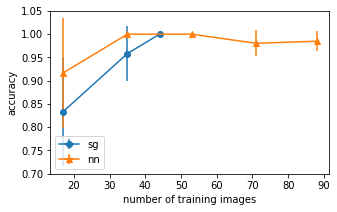

In [34]:
# plot accuracies obtained at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], sg_accs['val'], sg_accs['std'], sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], nn_accs['val'], nn_accs['std'], nn_nums['train_nums_std'], marker='^')
plt.xlabel('number of training images')
plt.ylabel('accuracy')
plt.legend(['sg', 'nn'])
plt.title('Method performance for different dataset sizes')
plt.savefig('results/sg_performance.png')

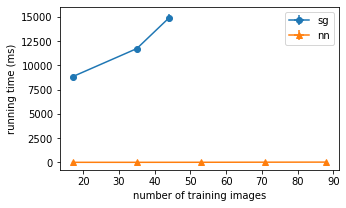

In [35]:
# plot model running times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], np.array(sg_times['run_t'])*1000, \
             np.array(sg_times['run_t_std'])*1000, sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['run_t'])*1000, \
             np.array(nn_times['run_t_std'])*1000, nn_nums['train_nums_std'], marker='^')
plt.xlabel('number of training images')
plt.ylabel('running time (ms)')
plt.legend(['sg', 'nn'])
plt.title('Method runtimes for different dataset sizes')
plt.savefig('results/sg_runtimes.png')

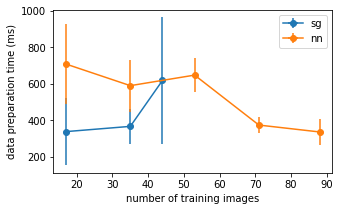

In [36]:
# plot data preparation times at different sizes
plt.figure(figsize=(5,3))
plt.errorbar(sg_nums['train_nums'], np.array(sg_times['data_t'])*1000, \
             np.array(sg_times['data_t_std'])*1000, sg_nums['train_nums_std'], marker='o')
plt.errorbar(nn_nums['train_nums'], np.array(nn_times['data_t'])*1000, \
             np.array(nn_times['data_t_std'])*1000, nn_nums['train_nums_std'], marker='o')
plt.xlabel('number of training images')
plt.ylabel('data preparation time (ms)')
plt.legend(['sg', 'nn'])
plt.title('Method preprocessing times for different sizes')
plt.savefig('results/sg_pretimes4sizes.png')